# Лабораторная работа 7

## Автоассоциативные сети с узким горлом

### Тимофеев А. В., М8О-407Б-19

Целью работы является исследование свойств автоассоциативных сетей с узким горлом,
алгоритмов обучения, а также применение сетей для выполнения линейного и нелинейного
анализа главных компонент набора данных.

Вариант 12

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange

from torch.utils.data.dataloader import default_collate

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Обучение на " + device)

Обучение на cuda


In [3]:
cifar10_data = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [4]:
cifar10_img = [[] for _ in range(10)]

for elem in cifar10_data:
    (x,y) = elem
    cifar10_img[y].append(2 * x - 1)

In [5]:
CLASS_CIFAR = 12 % 10

In [6]:
def displayImg(data, max_n=8, titles=None):
    n = min(max_n, len(data))
    fig, ax = plt.subplots(1, n, figsize=(2 * n, 2))
    for i in range(n):
        img = data[i].detach().cpu().numpy()
        img = (img + 1) / 2
        ax[i].imshow(img.transpose(1, 2, 0))
        ax[i].axis("off")
        if titles != None:
            ax[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

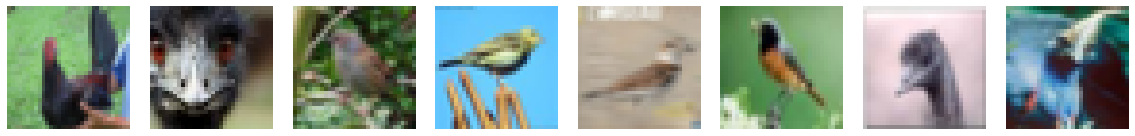

In [7]:
displayImg(cifar10_img[CLASS_CIFAR])

In [8]:
DIM1 = 32 * 32 * 3
DIM2 = 6144
DIM3 = 1024
DIM4 = 128

encoder = nn.Sequential(
    nn.Linear(DIM1, DIM2),
    nn.Linear(DIM2, DIM3),
    nn.Linear(DIM3, DIM4),
    nn.Tanh(),
).cuda()

decoder = nn.Sequential(
    nn.Linear(DIM4, DIM3),
    nn.Linear(DIM3, DIM2),
    nn.Linear(DIM2, DIM1),
    nn.Tanh(),
).cuda()

In [9]:
crit = torch.nn.MSELoss()

In [10]:
def fit(model_enc, model_dec, imgs, epoches=10, lr=1e-3):
    model_enc.train()
    model_dec.train()
    optim_enc = torch.optim.Adam(model_enc.parameters(), lr=lr)
    optim_dec = torch.optim.Adam(model_dec.parameters(), lr=lr)
    n = len(imgs)

    for i in range(n):
        imgs[i] = imgs[i].flatten().to(device)
    h = {"mse": []}

    for epoch in trange(epoches, desc="Traning autoencoder", ascii=True):
        train_loss_ep = 0.0

        for img in imgs:
            features = model_enc(img)
            img_out = model_dec(features)
            loss = crit(img, img_out)
            loss.backward()
            optim_dec.step()
            optim_enc.step()
            optim_dec.zero_grad()
            optim_enc.zero_grad()
            train_loss_ep += loss.detach().cpu().item() / n
        h["mse"].append(train_loss_ep)
    figure = plt.figure(figsize=(16, 9))
    axes = figure.add_subplot(111)
    plt.plot(h["mse"])
    plt.ylabel("MSE")
    plt.xlabel("Эпохи")
    plt.show()
    del optim_enc
    del optim_dec
    if device == "cuda":
        torch.cuda.empty_cache()

Traning autoencoder: 100%|##########| 150/150 [56:13<00:00, 22.49s/it]


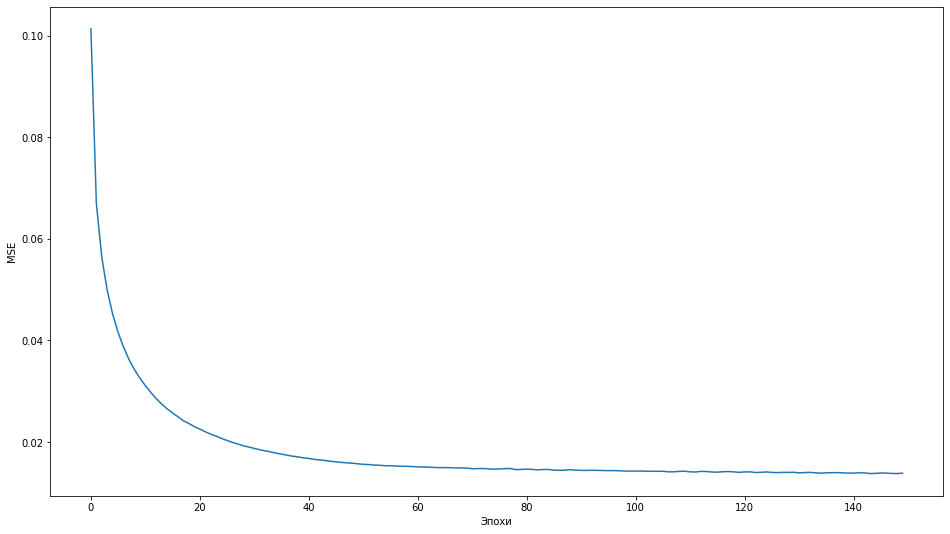

In [11]:
fit(encoder, decoder, cifar10_img[CLASS_CIFAR], epoches=150, lr=1e-5)

In [12]:
CIFAR_FRAME = 3


def drawImags(model_enc, model_dec, img, n_features, n_imgs=6):
    model_enc.eval()
    model_dec.eval()
    img = img.flatten().to(device)
    features = model_enc(img)
    img_out = model_dec(features)
    imgs = []
    imgs.append(img)
    imgs.append(img_out)
    n = 2 + n_imgs

    for _ in range(n_imgs):
        ids = np.random.randint(0, DIM4, n_features)
        vals = 2 * np.random.rand(n_features) - 1
        features_changed = features.detach().clone()

        for j, elem in enumerate(ids):
            features_changed[elem] = vals[j]
        imgs.append(model_dec(features_changed))

    for i in range(n):
        imgs[i] = imgs[i].reshape(3, 32, 32)
    titles = ["Модифицированный\nвектор"]
    titles = ["Исходное\nизображение", "Выход\nавтокодировщика"] + titles * n_imgs
    displayImg(imgs, n, titles=titles)

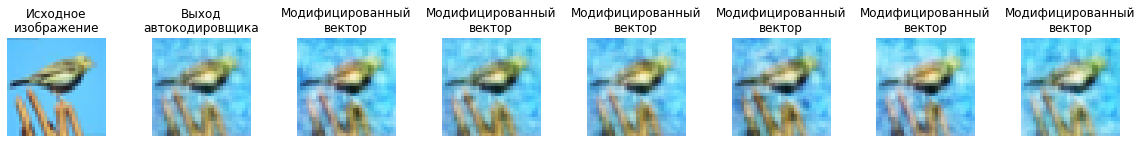

In [13]:
drawImags(encoder, decoder, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 4)

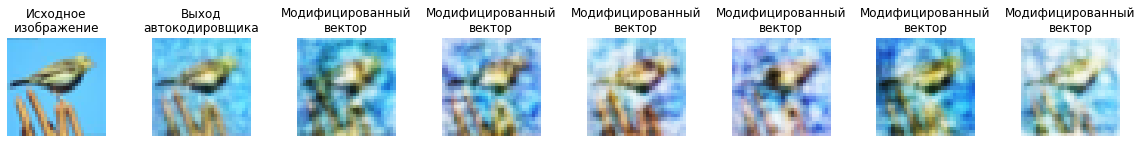

In [21]:
drawImags(encoder, decoder, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 24)

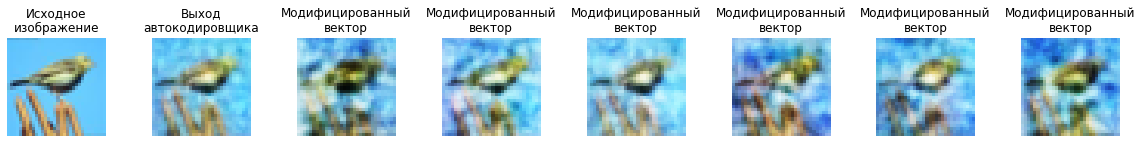

In [15]:
drawImags(encoder, decoder, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 16)

In [16]:
DIM1 = 32 * 32 * 3
DIM2 = 1024
DIM3 = 512
DIM4 = 128

encoder2 = nn.Sequential(
    nn.Linear(DIM1, DIM2),
    nn.Linear(DIM2, DIM3),
    nn.Linear(DIM3, DIM4),
    nn.Tanh(),
).cuda()

decoder2 = nn.Sequential(
    nn.Linear(DIM4, DIM3),
    nn.Linear(DIM3, DIM2),
    nn.Linear(DIM2, DIM1),
    nn.Tanh(),
).cuda()

crit = torch.nn.MSELoss()

Traning autoencoder: 100%|##########| 100/100 [06:36<00:00,  3.97s/it]


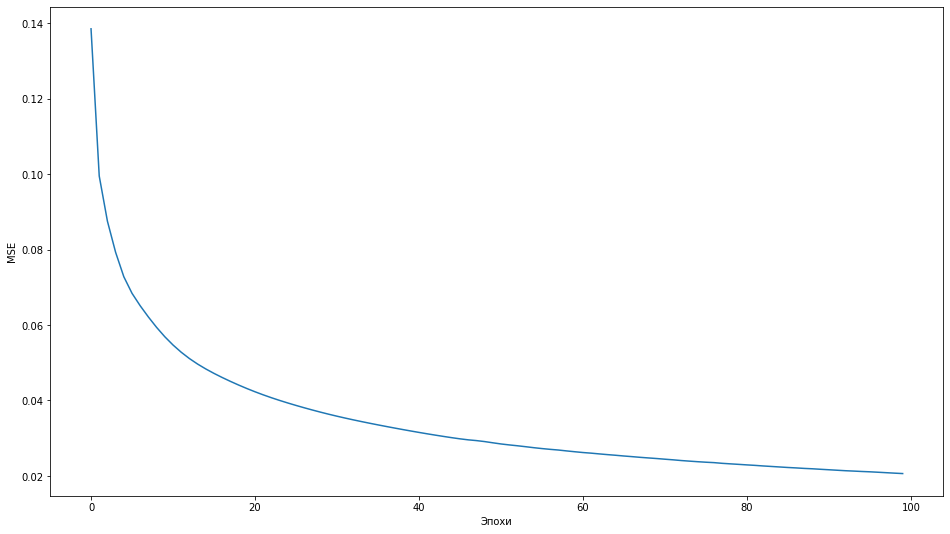

In [17]:
fit(encoder2, decoder2, cifar10_img[CLASS_CIFAR], epoches=150, lr=1e-5)

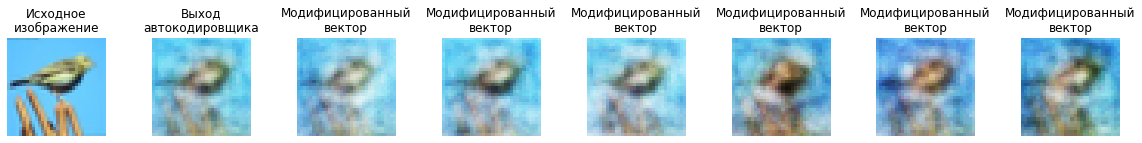

In [18]:
drawImags(encoder2, decoder2, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 16)

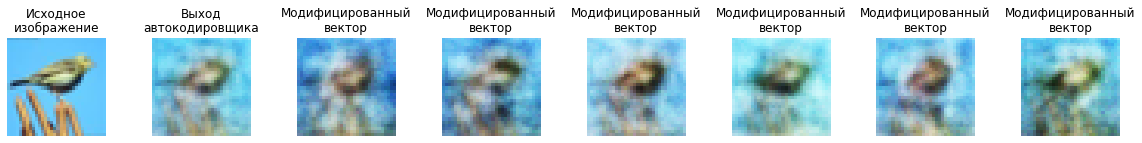

In [19]:
drawImags(encoder2, decoder2, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 24)

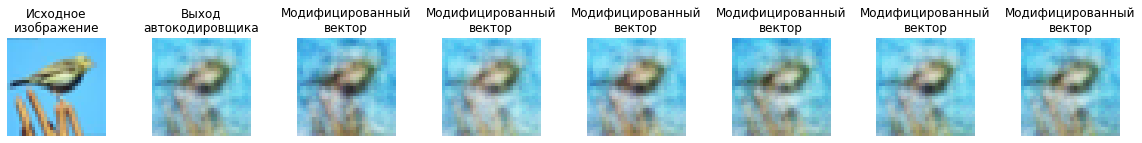

In [20]:
drawImags(encoder2, decoder2, cifar10_img[CLASS_CIFAR][CIFAR_FRAME], 4)

### Вывод

Выполнив лабораторную работу № 7 я исследовал архитектуру автоэнкодера и набор данных CIFAR-10, далее я обучил автоэнкодера на классе птиц из этого набора данных.